In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json
import matplotlib
import math
import string
import os

from matplotlib.colors import LogNorm

plt.rcParams["font.family"] = "arial"

### Load data dictionaries

In [2]:
full_sequences = 'Data/all_searches_concatenated_full_length_sequences_after_validation_more_than_60_seqID.fasta'

In [3]:
taxonomy = json.load(open('Data/all_searches_concatenated_taxonomy_after_validation_more_than_60_seqID.json', 'r'))
ecod_data = json.load(open('Data/ecod.latest.F70_selected_propellers_with_pinwheels_and_prisms.json'))
ecod_mapping = json.load(open('Data/all_searches_concatenated_propellers_sequences_after_validation_more_than_60_seqID_domains_annotate_ecod_mapping.json', 'r'))
domain_mapping = json.load(open('Data/all_searches_concatenated_full_length_sequences_after_validation_more_than_60_seqID_domains_annotated.json', 'r'))

### Make a table with all full-length proteins and their sequence features

In [4]:
min_cov = 30
domain_compositions = []

# add sequence lengths to protein domain annotation
with open(full_sequences, 'r') as infasta:
    for line in infasta:
        if line.startswith('>'):
            ncbi_code = line.split('|')[0].replace('>','')
        else:
            sequence = line.strip()
            if ncbi_code in domain_mapping:
                domain_mapping[ncbi_code]['protein_length'] = len(sequence)
                
# update the domain mapping dictionary with the simplified domain names, excluding domains
# whose coverage is below a value (e.g. 50%)

for protein in domain_mapping:
    
    annotated_domains = domain_mapping[protein]['annotated_domains']
    
    # annotate ecod classification of propellers

    ecod_t_names = [0 for propeller in [domain for domain in annotated_domains if 'blades' in domain]]
    ecod_f_names = [0 for propeller in [domain for domain in annotated_domains if 'blades' in domain]]
    ecod_prob = [0 for propeller in [domain for domain in annotated_domains if 'blades' in domain]]

    for ecod_pdb in ecod_mapping:
        for index, match in enumerate(ecod_mapping[ecod_pdb]['matched_propellers']):
            if protein in match:
                propeller_index = int(match.split('#')[-1].split('(')[0])-1
    
                f_name = ecod_mapping[ecod_pdb]['f']
                if len(f_name.split('_')) > 1:
                    if len(f_name.split('_')) > 1:
                        f_name = '_'.join(f_name.split('_')[:2])
                        if f_name.split('_')[-1].isdigit():
                            f_name = f_name.split('_')[0]
                ecod_f_names[propeller_index] = f_name

                t_name = ecod_mapping[ecod_pdb]['t']
                if len(t_name.split(' ')) > 1:
                    if len(t_name.split(' ')) > 4:
                        if 'domain' in t_name.split(' ')[-1]:
                            t_name = ' '.join(t_name.split(' ')[:-1])
                        else:
                            t_name = ' '.join(t_name.split(' ')[-4:])
                ecod_t_names[propeller_index] = t_name
                
                prob = ecod_mapping[ecod_pdb]['match_probability'][index]
                ecod_prob[propeller_index] = prob

    domain_mapping[protein]['propeller_t_name'] = ecod_t_names
    domain_mapping[protein]['propeller_f_name'] = ecod_f_names
    domain_mapping[protein]['propeller_probability'] = ecod_prob
    domain_mapping[protein]['number_propellers'] = len(domain_mapping[protein]['propeller_t_name'])
    
    # annotate the other domains
        
    domains = []
    repet_propeller_classifications = []
    repet_propeller_termini_distances = []
    repet_propeller_protein_full_coverage = []
    repet_propeller_termini_distance_types = []
    repet_propeller_intervals = []
    count_highly_repetitive = 0
    
    for i, domain in enumerate(annotated_domains):
        cov = 100
        if 'Partial' in domain:
            cov = int(domain.split('%)')[0].split('(')[-1])
            domain = ' '.join(domain.split('%) ')[1:])
        
        if 'blades' in domain and 'X:' not in domain: # if we are dealing with a highly repetitive propeller
            # check if it is followed or preceeded by a partial propeller match. 
            # if so, define the highly repetitive propeller as incomplete (so that later it is ignored)
            repet_propeller_classification = 'Globally'
            if i > 0 and 'Partial' in annotated_domains[i-1] and 'beta-propeller' in annotated_domains[i-1]:
                repet_propeller_classification = 'Locally'
            elif i < len(annotated_domains)-1 and 'Partial' in annotated_domains[i+1] and 'beta-propeller' in annotated_domains[i+1]:
                repet_propeller_classification = 'Locally'

            repet_propeller_classifications.append(repet_propeller_classification)

            domain = 'beta-propeller {}'.format(ecod_f_names[count_highly_repetitive])
            count_highly_repetitive += 1

            # check its distance to the N and C termini. Get the lowest of these distances.
            repet_propeller_interval = domain_mapping[protein]['annotated_intervals'][i]
            Ntermini_distance = repet_propeller_interval[0]
            Ctermini_distance = domain_mapping[protein]['protein_length'] - repet_propeller_interval[-1]
                        
            if  Ctermini_distance < Ntermini_distance:
                termini_distance = Ctermini_distance
                distance_type = 'C'
            else:
                termini_distance = Ntermini_distance
                distance_type = 'N'
            
            repet_propeller_termini_distances.append(termini_distance)
            repet_propeller_termini_distance_types.append(distance_type)
            repet_propeller_protein_full_coverage.append((repet_propeller_interval[-1]-repet_propeller_interval[0])*100/domain_mapping[protein]['protein_length'])
            repet_propeller_intervals.append(repet_propeller_interval)
            
        if cov >= min_cov:  
            if 'F:' in domain:
                if 'beta-propeller' not in domain:
                    # take the t_level as the name of domain
                    if domain.split(' F:')[0].split(' T: ')[-1] == 'N-terminal':
                        domain = domain.split(' F:')[0].split(' T: ')[-1] + domain.split(' F:')[-1]
                    else:
                        domain = domain.split(' F:')[0].split(' T: ')[-1]
                    
                else:
                    domain = 'beta-propeller'
            #print(domain)
            domains.append(domain)
        else:
            domains.append('')
            
    domain_mapping[protein]['simplified_domain_annot'] = '*'.join([domain for domain in domains if domain != ''])
    domain_mapping[protein]['repet_propeller_classifications'] = repet_propeller_classifications
    domain_mapping[protein]['repet_propeller_termini_distances'] = repet_propeller_termini_distances
    domain_mapping[protein]['repet_propeller_termini_distance_types'] = repet_propeller_termini_distance_types
    domain_mapping[protein]['repet_propeller_protein_coverage'] = repet_propeller_protein_full_coverage
    domain_mapping[protein]['repet_propeller_intervals'] = repet_propeller_intervals
    
    domain_composition = sorted(list(set([domain for domain in domains if domain != ''])))
    domain_composition = '*'.join(domain_composition)
    domain_mapping[protein]['domain_composition'] = domain_composition
                  
# get taxonomy now
for superkingdom in taxonomy:
    for phylum in taxonomy[superkingdom]:
        if "Candidat" in phylum or "candidat" in phylum:
            phylum_real = 'candidate phyla'
        else:
            phylum_real = phylum
        
        for taxclass in taxonomy[superkingdom][phylum]:
            for order in taxonomy[superkingdom][phylum][taxclass]:
                for genus in taxonomy[superkingdom][phylum][taxclass][order]:
                    for species in taxonomy[superkingdom][phylum][taxclass][order][genus]:
                        for ncbi_code in taxonomy[superkingdom][phylum][taxclass][order][genus][species]['ncbi_codes']:
                                
                            domain_mapping[ncbi_code]['Superkingdom'] = superkingdom
                            domain_mapping[ncbi_code]['Phylum'] = phylum_real
                            domain_mapping[ncbi_code]['Class'] = taxclass
                            domain_mapping[ncbi_code]['Order'] = order
                            domain_mapping[ncbi_code]['Genus'] = genus
                            domain_mapping[ncbi_code]['Species'] = species

# Create datframe
full_sequences_df = {'ncbi_code': []}

for protein in domain_mapping:
    full_sequences_df['ncbi_code'].append(protein)
    for key in domain_mapping[protein]:
        if key != 'seq':
            if key not in full_sequences_df:
                full_sequences_df[key]= []
            full_sequences_df[key].append(domain_mapping[protein][key])
            
full_sequences_df = pd.DataFrame(full_sequences_df)
full_sequences_df.sort_values(by='number_propellers')

,ncbi_code,annotated_domains,annotated_intervals,protein_length,propeller_t_name,propeller_f_name,propeller_probability,number_propellers,simplified_domain_annot,repet_propeller_classifications,...,repet_propeller_termini_distance_types,repet_propeller_protein_coverage,repet_propeller_intervals,domain_composition,Superkingdom,Phylum,Class,Order,Genus,Species
0,RTZ68428.1,"[beta-propeller 6-blades, Partial (89%) X: Fla...","[[54, 300], [391, 679], [682, 749], [809, 855]...",1288,[7-bladed],[Peptidase_S9],[[99.8]],1,beta-propeller Peptidase_S9*Periplasmic bindin...,[Globally],...,[N],[19.099378881987576],"[[54, 300]]",Periplasmic binding protein-like I*Periplasmic...,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium
6579,ASN82586.1,[Partial (62%) X: Rossmann-like T: PreATP-gras...,"[[63, 122], [177, 234], [261, 441]]",454,[7-bladed],[RCC1],[[99.7]],1,PreATP-grasp domain*Cystatin/monellin*beta-pro...,[Globally],...,[C],[39.647577092511014],"[[261, 441]]",Cystatin/monellin*PreATP-grasp domain*beta-pro...,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcus,Deinococcus ficus
6580,WP_056301768.1,[Partial (30%) X: Immunoglobulin-like beta-san...,"[[70, 128], [384, 730]]",735,[7-bladed],[RCC1],[[100.0]],1,Immunoglobulin/Fibronectin type III/E set doma...,[Globally],...,[C],[47.074829931972786],"[[384, 730]]",Immunoglobulin/Fibronectin type III/E set doma...,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcus,Deinococcus sp. Leaf326
6581,WP_056303166.1,[beta-propeller 7-blades],"[[166, 493]]",504,[7-bladed],[RCC1],[[100.0]],1,beta-propeller RCC1,[Globally],...,[C],[64.88095238095238],"[[166, 493]]",beta-propeller RCC1,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcus,Deinococcus sp. Leaf326
6582,WP_136387281.1,[Partial (16%) X: Other Rossmann-like structur...,"[[128, 185], [275, 516]]",526,[7-bladed],[RCC1],[[99.8]],1,beta-propeller RCC1,[Globally],...,[C],[45.81749049429658],"[[275, 516]]",beta-propeller RCC1,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcus,Deinococcus sp. KSM4-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809,WP_094572320.1,"[beta-propeller 5-blades, beta-propeller 5-bla...","[[114, 344], [205, 479], [488, 541], [541, 815...",2465,"[6-bladed, 6-bladed, 6-bladed, 6-bladed, 6-bla...","[GSDH, GSDH, GSDH, GSDH, GSDH, GSDH]","[[99.5], [98.5], [98.5], [98.5], [98.5], [99.5]]",6,beta-propeller GSDH*beta-propeller GSDH*beta-p...,"[Globally, Locally, Locally, Locally, Locally,...",...,"[N, N, N, N, C, C]","[9.330628803245435, 11.115618661257606, 11.115...","[[114, 344], [205, 479], [541, 815], [877, 115...",Galactose-binding domain-like*Immunoglobulin/F...,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Mucilaginibacter,Mucilaginibacter sp. BJC16-A31
619,WP_052639606.1,"[beta-propeller 4-blades, beta-propeller 5-bla...","[[270, 584], [364, 603], [835, 1146], [931, 11...",1878,"[7-bladed, ABC toxin B component, ABC toxin B ...","[VCBS, VCBS, VCBS, VCBS, VCBS, VCBS]","[[99.9], [99.7], [99.8], [99.7], [99.8], [99.7]]",6,beta-propeller VCBS*beta-propeller VCBS*beta-p...,"[Globally, Globally, Globally, Globally, Globa...",...,"[N, N, C, C, C, C]","[16.719914802981897, 12.726304579339724, 16.56...","[[270, 584], [364, 603], [835, 1146], [931, 11...",Jelly-roll domain in distal tail protein (Dit)...,Bacteria,Planctomycetes,Planctomycetia,Gemmatales,Zavarzinella,Zavarzinella formosa
1585,TWH71263.1,"[X: HTH T: winged F: LexA_DNA_bind_like, Parti...","[[83, 136], [470, 516], [1170, 1477], [1539, 1...",4165,"[7-bladed, 7-bladed, 7-bladed, 7-bladed, 7-bla...","[ANAPC4_WD40, ANAPC4_WD40, ANAPC4_WD40, ANAPC4...","[[99.9], [99.9], [99.9], [99.9], [99.9], [99.9...",8,winged*beta-propeller ANAPC4_WD40*beta-propell...,"[Globally, Globally, Globally, Globally, Globa...",...,"[N, N, N, C, C, C, C, C]","[7.3709483793517405, 7.539015606242497, 7.3709...","[[1170, 1477], [1539, 1853], [1925, 2232], [23...",bet

### Make a table with all highly repetitive propellers and their data

In [5]:
contract_names = True
min_similarity = 60
propellers = {}

# get ecod mapping first

for target in ecod_mapping:
    f_name = ecod_mapping[target]['f']
    if contract_names and len(f_name.split('_')) > 1:
        if len(f_name.split('_')) > 1:
            f_name = '_'.join(f_name.split('_')[:2])
            if f_name.split('_')[-1].isdigit():
                f_name = f_name.split('_')[0]
    
    t_name = ecod_mapping[target]['t']
    if contract_names and len(t_name.split(' ')) > 1:
        if len(t_name.split(' ')) > 4:
            if 'domain' in t_name.split(' ')[-1]:
                t_name = ' '.join(t_name.split(' ')[:-1])
            else:
                t_name = ' '.join(t_name.split(' ')[-4:])
    
    if len(ecod_mapping[target]['number_blades']) > 0:
        number_blades = max(ecod_mapping[target]['number_blades'])
    else:
        number_blades = np.nan
    
    for propeller in ecod_mapping[target]['matched_propellers']:
        propeller_label = propeller.split('(')[0]
        blade_similarity = float(propeller.split(': ')[-1].split('%')[0])
        if propeller_label not in propellers and blade_similarity >= min_similarity:
            propellers[propeller_label] = {'parent_f_name': f_name,
                                     'parent_t_name': t_name,
                                     'detected_topology': int(propeller.split('(')[-1].split()[0]),
                                     'blades_similarity': blade_similarity}


# get taxonomy and propeller classification now

for superkingdom in taxonomy:
    for phylum in taxonomy[superkingdom]:
        if "Candidat" in phylum or "candidat" in phylum:
            phylum_real = 'candidate phyla'
        else:
            phylum_real = phylum
        
        for taxclass in taxonomy[superkingdom][phylum]:
            for order in taxonomy[superkingdom][phylum][taxclass]:
                for genus in taxonomy[superkingdom][phylum][taxclass][order]:
                    for species in taxonomy[superkingdom][phylum][taxclass][order][genus]:
                        for propeller in propellers:
                            ncbi_code = propeller.split('_#')[0]
                            propeller_index = int(propeller.split('_#')[-1])-1
                            
                            if ncbi_code in taxonomy[superkingdom][phylum][taxclass][order][genus][species]['ncbi_codes']:
                                
                                propellers[propeller]['Superkingdom'] = superkingdom
                                propellers[propeller]['Phylum'] = phylum_real
                                propellers[propeller]['Class'] = taxclass
                                propellers[propeller]['Order'] = order
                                propellers[propeller]['Genus'] = genus
                                propellers[propeller]['Species'] = species
                                
                                propeller_classification = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_classification = propeller_classification.iloc[0]['repet_propeller_classifications']
                                propeller_classification = propeller_classification[propeller_index]
                                
                                propeller_distances = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_distances = propeller_distances.iloc[0]['repet_propeller_termini_distances']
                                propeller_distances = propeller_distances[propeller_index]
                                
                                propeller_distance_types = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_distance_types = propeller_distance_types.iloc[0]['repet_propeller_termini_distance_types']
                                propeller_distance_types = propeller_distance_types[propeller_index]
                                
                                propeller_protein_coverage = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_protein_coverage = propeller_protein_coverage.iloc[0]['repet_propeller_protein_coverage']
                                propeller_protein_coverage = propeller_protein_coverage[propeller_index]
                                
                                propeller_interval = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_interval = propeller_interval.iloc[0]['repet_propeller_intervals']
                                propeller_interval = propeller_interval[propeller_index]
                                
                                propeller_probability = full_sequences_df.loc[full_sequences_df.ncbi_code == ncbi_code]
                                propeller_probability = propeller_probability.iloc[0]['propeller_probability']
                                try:
                                    propeller_probability = propeller_probability[propeller_index][0]
                                    if type(propeller_probability) == list:
                                        propeller_probability = 0                                    
                                except:
                                    propeller_probability = 0

                                propellers[propeller]['Classification'] = propeller_classification
                                propellers[propeller]['Termini_distance'] = propeller_distances
                                propellers[propeller]['Termini_distance_type'] = propeller_distance_types
                                propellers[propeller]['Protein_coverage'] = propeller_protein_coverage
                                propellers[propeller]['Propeller_probability'] = propeller_probability
                                propellers[propeller]['Propeller_interval'] = propeller_interval
                                
                                
                
propellers_df = {'propeller': []}

for propeller in propellers:
    propellers_df['propeller'].append(propeller)
    for key in propellers[propeller]:
        if key not in propellers_df:
            propellers_df[key] = []
        
        propellers_df[key].append(propellers[propeller][key])

propellers_df_df = pd.DataFrame(propellers_df)
propellers_df_df.set_index('propeller')
propellers_df_df

,propeller,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,Classification,Termini_distance,Termini_distance_type,Protein_coverage,Propeller_probability,Propeller_interval
0,RTZ68428.1_#1,Peptidase_S9,7-bladed,6,62.50,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,54,N,19.099379,99.8,"[54, 300]"
1,PYK27766.1_#1,Peptidase_S9,7-bladed,6,61.11,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,49,N,57.342657,99.8,"[49, 295]"
2,PYL57328.1_#1,Peptidase_S9,7-bladed,3,63.64,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,27,C,63.485477,99.3,"[61, 214]"
3,RPF85337.1_#1,Peptidase_S9,7-bladed,2,80.77,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Roseibacillus,Roseibacillus sp. TMED18,Globally,154,N,7.393365,96.3,"[154, 232]"
4,PJA83838.1_#1,Peptidase_S9,7-bladed,5,64.17,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Nealsonbacteria bacterium CG_4_9_14...,Globally,42,N,30.266344,99.8,"[42, 292]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469,WP_020404944.1_#2,SGL,6-bladed,2,72.97,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanothermococcus,Methanothermococcus thermolithotrophicus,Globally,0,C,39.613527,98.3,"[125, 207]"
10470,WP_013142820.1_#1,SGL,6-bladed,7,65.83,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Staphylothermus,Staphylothermus hellenicus DSM 12710,Globally,30,N,29.312169,99.9,"[30, 307]"
10471,RZD33336.1_#1,ANAPC4_WD40,8-bladed,8,62.50,Archaea,Euryarchaeota,na,na,Euryarchaeota,Euryarchaeota archaeon,Globally,30,N,43.360434,100.0,"[30, 350]"
10472,WP_131006923.1_#1,ANAPC4_WD40,8-bladed,9,78.12,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanofervidicoccus,Methanofervidicoccus abyssi,Globally,85,C,60.617060,99.9,"[132, 466]"


# RESULTS ANALYSIS

In [6]:
out_dir = 'plots_for_paper'
os.mkdir(out_dir)

## Get a grasp of the ECOD families (f_name) matched

In [7]:
def get_colors(all_labels, cmap = 'Spectral'):
    
    # define families colors

    all_labels = sorted(list(set(all_labels)))
        
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(all_labels))

    colours = [cmap(norm(i)) for i in range(len(all_labels))]
    
    return colours

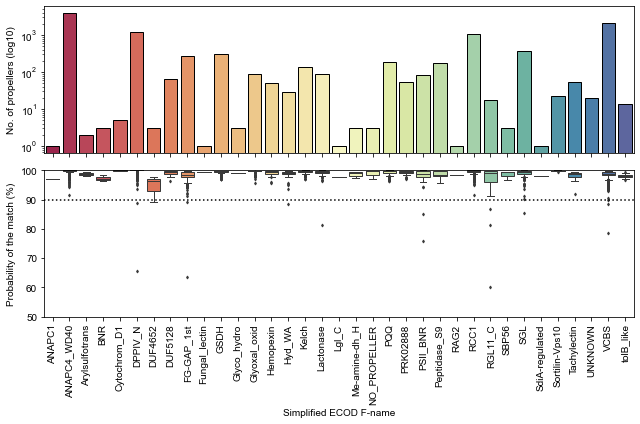

In [8]:
# f-names
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,6))

sns.countplot(x='parent_f_name', data=propellers_df_df, palette='Spectral', edgecolor='black', linewidth=1, log=True,
              order=sorted(set(propellers_df_df.parent_f_name)), ax=ax1)
ax1.set_ylabel('No. of propellers (log10)')
ax1.set_xlabel('')

sns.boxplot(y='Propeller_probability', data=propellers_df_df, palette='Spectral', linewidth=1,
            x='parent_f_name', order=sorted(set(propellers_df_df.parent_f_name)), fliersize=2, ax=ax2)
ax2.hlines(90, -1, len(set(propellers_df_df.parent_f_name)), color='k', linestyle=':')
ax2.set_ylabel('Probability of the match (%)')
ax2.set_ylim(50, 100)
ax2.set_xlabel('Simplified ECOD F-name')
ax2.set_xticklabels(rotation=90, labels = sorted(set(propellers_df_df.parent_f_name)))
ax2.set_xlim(-0.5, len(set(propellers_df_df.parent_f_name))-0.5)

f.tight_layout()
f.savefig('{}/fig1AB.pdf'.format(out_dir))

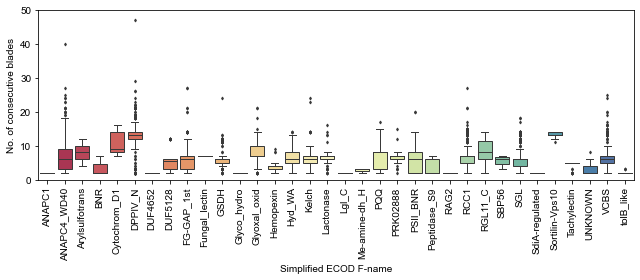

In [61]:
# f-names
f, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(9,4))

sns.boxplot(y='detected_topology', data=propellers_df_df, palette='Spectral', linewidth=1,
            x='parent_f_name', order=sorted(set(propellers_df_df.parent_f_name)), fliersize=2, ax=ax1)
ax1.set_ylabel('No. of consecutive blades')
ax1.set_ylim(0, 50)
ax1.set_xlabel('')
ax1.set_xticklabels(rotation=90, labels = sorted(set(propellers_df_df.parent_f_name)))
ax1.set_xlim(-0.5, len(set(propellers_df_df.parent_f_name))-0.5)
ax1.set_xlabel('Simplified ECOD F-name')

plt.tight_layout()
f.savefig('{}/S2.pdf'.format(out_dir))

In [12]:
# for pie plot

def get_all_ecod_names(ecod_data, level):
    
    ecod_names = []
    
    for target in ecod_data:
        if 'blades' in ecod_data[target]:
            label = ecod_data[target][level]         
            if level == 'f' and contract_names:
                if len(label.split('_')) > 1:
                    if len(label.split('_')) > 1:
                        label = '_'.join(label.split('_')[:2])
                        if label.split('_')[-1].isdigit():
                            label = label.split('_')[0]

            elif level == 't' and contract_names:
                if len(label.split(' ')) > 1:
                    if len(label.split(' ')) > 4:
                        if 'domain' in label.split(' ')[-1]:
                            label = ' '.join(label.split(' ')[:-1])
                        else:
                            label = ' '.join(label.split(' ')[-4:])

            ecod_names.append(label)
#         else:
#             print(ecod_data[target][level])
                    
    return list(set(ecod_names))

def get_matched_ecod_names(ecod_mapping, level):

    ecod_names = []
    
    for target in ecod_mapping:
        label = ecod_mapping[target][level]         
        if level == 'f' and contract_names:
                if len(label.split('_')) > 1:
                    label = '_'.join(label.split('_')[:2])
                    if label.split('_')[-1].isdigit():
                        label = label.split('_')[0]

        elif level == 't' and contract_names:
            if len(label.split(' ')) > 4:
                if 'domain' in label.split(' ')[-1]:
                    label = ' '.join(label.split(' ')[:-1])
                else:
                    label = ' '.join(label.split(' ')[-4:])

        ecod_names.append(label)
        
    return list(set(ecod_names))

In [13]:
data = {'Category': ['Families matched', 'Families not matched', 'New families matched'], 
            'colours': ['grey', 'white', 'silver'],
            'members': [0, 0, 0],
            'count': [0, 0, 0]}
    
# get all famlies (exclude those that were not considered to select seeds - those for which symmetry was not even barely automatically detectable)
all_families = get_all_ecod_names(ecod_data, 'f')
matched_families = get_matched_ecod_names(ecod_mapping, 'f')

unmatched_families = [familie for familie in all_families if familie not in matched_families]
new_families = [familie for familie in matched_families if familie not in all_families]
matched_families = [familie for familie in matched_families if familie not in new_families]

print(sorted(unmatched_families))

data['members'][0] = matched_families
data['members'][1] = unmatched_families
data['members'][2] = new_families

for i, category in enumerate(data['Category']):
    data['count'][i] = len(data['members'][i])

data = pd.DataFrame(data)
data['angle'] = data['count']/data['count'].sum() * 2*math.pi
data

['BBS1', 'B_lectin', 'Clathrin_propel', 'Coatomer_WDAD', 'DAP2', 'DNA_gyraseA', 'DUF1861', 'DUF1899', 'DUF4221', 'DUF4623_C', 'DUF4784_C', 'DUF5005', 'End_beta', 'F_UNCLASSIFIED', 'Glu_cyclase', 'HN', 'MMS1_N', 'MRJP', 'Mcl1_mid', 'NUP214', 'Neisseria_PilC', 'Neur', 'Nucleoporin_N', 'Nup160', 'OLF', 'PHTB1_N', 'Pep3_Vps18', 'Phytase', 'RPE65', 'Sema']


,Category,colours,members,count,angle
0,Families matched,grey,"[SGL, tolB_like, RAG2, Me-amine-dh_H, GSDH, Gl...",32,3.093260
1,Families not matched,white,"[End_beta, F_UNCLASSIFIED, Coatomer_WDAD, Mcl1...",30,2.899932
2,New families matched,silver,"[UNKNOWN, NO_PROPELLER, DUF4652]",3,0.289993


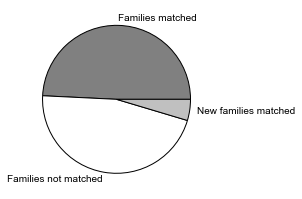

In [14]:
plt.figure(figsize=(4,4))
plt.pie(data['count'], colors=data['colours'], labels=data['Category'],wedgeprops={'linewidth': 1, 'edgecolor':'black'})
plt.tight_layout()
plt.savefig('{}/fig1C_pie.pdf'.format(out_dir))

## Get a grasp of the taxonomic distribution

In [15]:
propellers_df_df['taxlabel'] = ['{}_{}'.format(row.Superkingdom, row.Phylum) for index, row in propellers_df_df.iterrows()]

# exclude those that matched non-propeller folds
propellers_df_df = propellers_df_df.loc[propellers_df_df.parent_f_name != 'NO_PROPELLER']
propellers_df_df

,propeller,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,Classification,Termini_distance,Termini_distance_type,Protein_coverage,Propeller_probability,Propeller_interval,taxlabel
0,RTZ68428.1_#1,Peptidase_S9,7-bladed,6,62.50,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,54,N,19.099379,99.8,"[54, 300]",Bacteria_Verrucomicrobia
1,PYK27766.1_#1,Peptidase_S9,7-bladed,6,61.11,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,49,N,57.342657,99.8,"[49, 295]",Bacteria_Verrucomicrobia
2,PYL57328.1_#1,Peptidase_S9,7-bladed,3,63.64,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,Globally,27,C,63.485477,99.3,"[61, 214]",Bacteria_Verrucomicrobia
3,RPF85337.1_#1,Peptidase_S9,7-bladed,2,80.77,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Roseibacillus,Roseibacillus sp. TMED18,Globally,154,N,7.393365,96.3,"[154, 232]",Bacteria_Verrucomicrobia
4,PJA83838.1_#1,Peptidase_S9,7-bladed,5,64.17,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Nealsonbacteria bacterium CG_4_9_14...,Globally,42,N,30.266344,99.8,"[42, 292]",Bacteria_candidate phyla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469,WP_020404944.1_#2,SGL,6-bladed,2,72.97,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanothermococcus,Methanothermococcus thermolithotrophicus,Globally,0,C,39.613527,98.3,"[125, 207]",Archaea_Euryarchaeota
10470,WP_013142820.1_#1,SGL,6-bladed,7,65.83,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Staphylothermus,Staphylothermus hellenicus DSM 12710,Globally,30,N,29.312169,99.9,"[30, 307]",Archaea_Crenarchaeota
10471,RZD33336.1_#1,ANAPC4_WD40,8-bladed,8,62.50,Archaea,Euryarchaeota,na,na,Euryarchaeota,Euryarchaeota archaeon,Globally,30,N,43.360434,100.0,"[30, 350]",Archaea_Euryarchaeota
10472,WP_131006923.1_#1,ANAPC4_WD40,8-bladed,9,78.12,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanofervidicoccus,Methanofervidicoccus abyssi,Globally,85,C,60.617060,99.9,"[132, 466]",Archaea_Euryarchaeota


In [16]:
def get_level_taxonomy_heatmap(df, level, parameter = 'count', remove_singletons = False):

    # get matrix of values
    
    tax_labels = sorted(list(set(df.Superkingdom + '_' + df.Phylum)))
    
    if level == 'neighbour_domains':
        all_domains = [domain for architecture in df['domain_composition'] for domain in architecture.split('*') if domain != 'beta-propeller']
        names = sorted(list(set(all_domains)))
        names.append('single/multiple propellers')
    else:
        names = sorted(list(set(df[level])))
    
    matrix = np.array([[np.nan for tax in tax_labels] for f in names])
    matrix = pd.DataFrame(matrix, columns = tax_labels, index = names)
    
    if parameter == 'count':
        for index, row in df.iterrows():
            if level == 'neighbour_domains':
                curr_names = set([domain for domain in row['domain_composition'].split('*')])
            else:
                curr_names = [row[level]]
            for curr_name in curr_names:
                curr_tax_label = row.Superkingdom + '_' + row.Phylum
                
                if len(curr_names) == 1 and curr_name == 'beta-propeller':
                    curr_name = 'single/multiple propellers'
                
                if curr_name != 'beta-propeller':
                    if np.isnan(matrix[curr_tax_label][curr_name]):
                        matrix[curr_tax_label][curr_name] = 1
                    else:
                        matrix[curr_tax_label][curr_name] += 1
    else:
        for index, row in propellers_df.iterrows():
            curr_name = row[level]
            curr_tax_label = row.Superkingdom + '_' + row.Phylum
            if row[parameter] > matrix[curr_tax_label][curr_name] or np.isnan(matrix[curr_tax_label][curr_name]):
                matrix[curr_tax_label][curr_name] = row[parameter]
    
    if remove_singletons: # remove lines whose maximum value is 1
        matrix = matrix.loc[matrix.max(axis=1) > 1]
        names = list(matrix.index)
        
    # get cell colors
    cmap = matplotlib.cm.get_cmap('Greys')
    if parameter == 'count':
        norm = matplotlib.colors.LogNorm(vmin=matrix.min().min(), vmax=matrix.max().max())
    else:
        norm = matplotlib.colors.Normalize(vmin=matrix.min().min(), vmax=matrix.max().max())
        
    return matrix, names, norm

1224.0


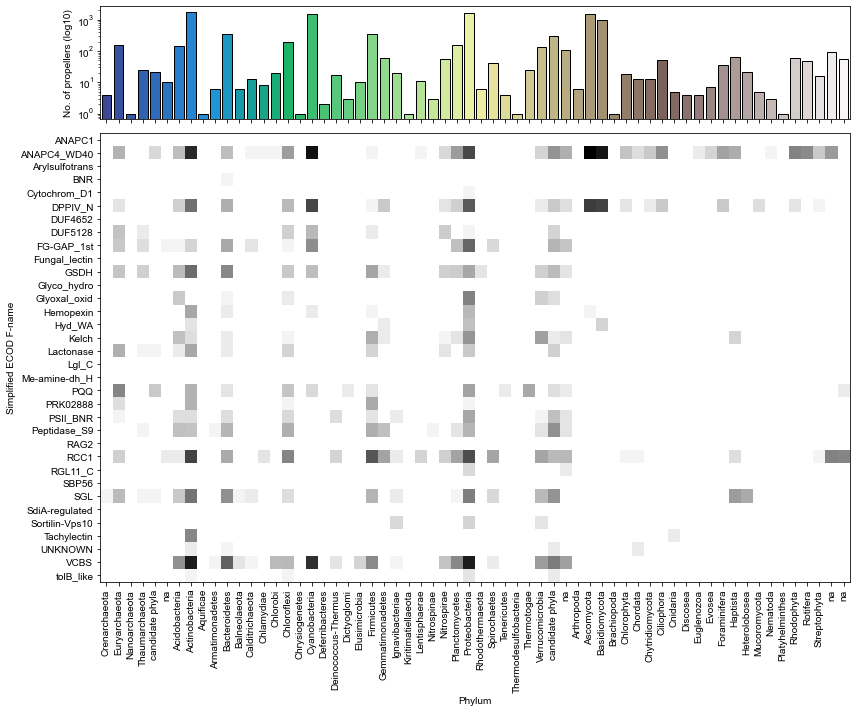

In [17]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12,10), gridspec_kw={'height_ratios':[1,4]})

sns.countplot(x='taxlabel', data=propellers_df_df, palette='terrain', edgecolor='black', linewidth=1, log=True,
              order=sorted(set(propellers_df_df.taxlabel)), ax=ax1)
ax1.set_ylabel('No. of propellers (log10)')
ax1.set_xlabel('')
ax1.set_xticklabels(labels = ['' for i in sorted(set(propellers_df_df.taxlabel))])

family_phylum_matrix, names, norm = get_level_taxonomy_heatmap(propellers_df_df, 'parent_f_name', parameter = 'count', remove_singletons = False)

res = sns.heatmap(pd.DataFrame(family_phylum_matrix), cmap='Greys', norm=norm, ax=ax2, cbar=False)
ax2.set_ylabel('Simplified ECOD F-name')
ax2.set_xlabel('Phylum')
ax2.set_xticklabels(rotation=90, labels = [i.split('_')[-1] for i in sorted(set(propellers_df_df.taxlabel))])
ax2.set_yticklabels(labels = sorted(set(propellers_df_df.parent_f_name)))
for _, spine in res.spines.items():
    spine.set_visible(True)

f.tight_layout()
f.savefig('{}/fig2AB.pdf'.format(out_dir))

print(family_phylum_matrix.max().max())

In [72]:
euk = propellers_df_df.loc[propellers_df_df.Superkingdom == 'Eukaryota']
Ascomycota = euk.loc[(euk.Phylum == 'Ascomycota')]
Basidiomycota = euk.loc[(euk.Phylum == 'Basidiomycota')]
print('Percentage of Ascomycota + Basidiomycota:', (len(Ascomycota)+len(Basidiomycota))*100/len(euk))

Percentage of Ascomycota + Basidiomycota: 84.38943894389439


## Compare number of blades in globally and locally repetitive propellers

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


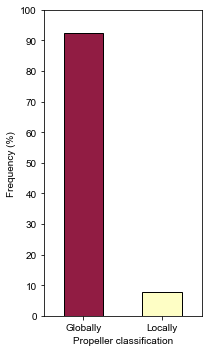

In [18]:
h = 5
w = 3
colors=['#911C43','#FEFEC5']

plt.figure(figsize=(w, h))
(propellers_df_df.Classification.value_counts()*100/len(propellers_df_df)).plot(kind='bar', rot=0, 
                                                                           colors=colors,
                                                                           edgecolor='black')
plt.ylabel('Frequency (%)')
plt.yticks(range(0,101,10))
plt.ylim(0,100)
plt.xlabel('Propeller classification')
plt.tight_layout()
plt.savefig('{}/fig3A.pdf'.format(out_dir))

all:  47
local:  29
global:  47


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


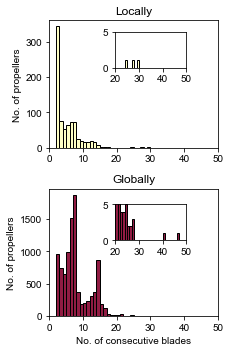

In [29]:
f, axs = plt.subplots(2, 1, figsize=(w+0.3,h))

propellers_df = pd.DataFrame(propellers_df)
print('all: ', propellers_df.detected_topology.max())

# first the Locally
Locally = propellers_df.loc[propellers_df.Classification == 'Locally']
print('local: ', Locally.detected_topology.max())

sns.histplot(Locally.detected_topology, bins=range(max(propellers_df.detected_topology)+1), 
             ax=axs[0], stat='count', color=colors[1], edgecolor='black', linewidth=1, alpha=1)
axs[0].set_xlim(0, 50)
axs[0].set_xlabel('')
axs[0].set_ylabel('No. of propellers')
axs[0].title.set_text('Locally')

ax0 = f.add_axes([0.5, 0.8, 0.3, 0.1])
sns.histplot(Locally[Locally.detected_topology>=20].detected_topology, bins=range(20,max(propellers_df.detected_topology)+1), 
             ax=ax0, stat='count', color=colors[1], edgecolor='black', linewidth=1, alpha=1)
ax0.set_xlim(20, 50)
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.set_ylim(0,5)
ax0.set_xticks(range(20, 60, 10))

# now the Globally
Globally = propellers_df.loc[propellers_df.Classification == 'Globally']
print('global: ', Globally.detected_topology.max())

sns.histplot(Globally.detected_topology, bins=range(max(propellers_df.detected_topology)+1), 
             ax=axs[1], stat='count', color=colors[0], edgecolor='black', linewidth=1, alpha=1)
axs[1].set_xlim(0, 50)
axs[1].set_ylabel('No. of propellers')
axs[1].set_xlabel('No. of consecutive blades')
axs[1].title.set_text('Globally')

ax1 = f.add_axes([0.5, 0.32, 0.3, 0.1])
sns.histplot(Globally[Globally.detected_topology>=20].detected_topology, bins=range(20,max(propellers_df.detected_topology)+1),
             ax=ax1, stat='count', color=colors[0], edgecolor='black', linewidth=1, alpha=1)
ax1.set_xlim(20, 50)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_ylim(0,5)
ax1.set_xticks(range(20, 60, 10))

plt.tight_layout()
plt.savefig('{}/fig3B-D.pdf'.format(out_dir))

Family:  ANAPC1 0
Family:  ANAPC4_WD40 3656


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  Arylsulfotrans 2
Family:  BNR 2
Family:  Cytochrom_D1 4
Family:  DPPIV_N 1160


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  DUF4652 0
Family:  DUF5128 59
Family:  FG-GAP_1st 255


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  Fungal_lectin 1
Family:  GSDH 296


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  Glyco_hydro 1
Family:  Glyoxal_oxid 85
Family:  Hemopexin 50
Family:  Hyd_WA 25
Family:  Kelch 130
Family:  Lactonase 86
Family:  Lgl_C 0
Family:  Me-amine-dh_H 2
Family:  PQQ 155


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Family:  PRK02888 53
Family:  PSII_BNR 64
Family:  Peptidase_S9 94
Family:  RAG2 1
Family:  RCC1 1008


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  RGL11_C 16
Family:  SBP56 2
Family:  SGL 351


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  SdiA-regulated 1
Family:  Sortilin-Vps10 22
Family:  Tachylectin 48
Family:  UNKNOWN 10
Family:  VCBS 2021


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Family:  tolB_like 5


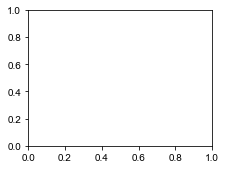

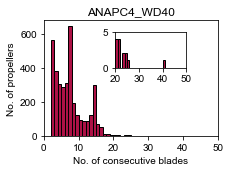

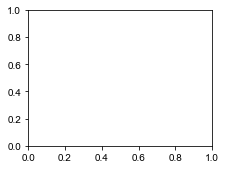

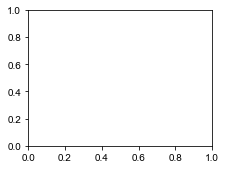

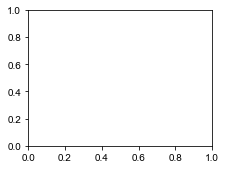

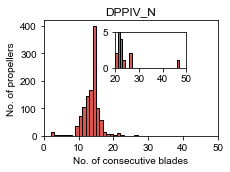

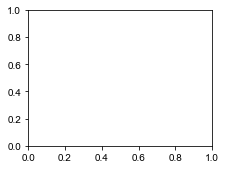

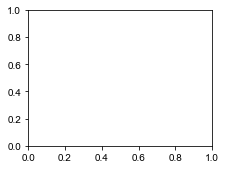

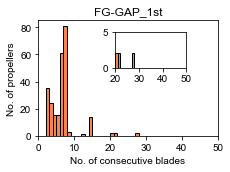

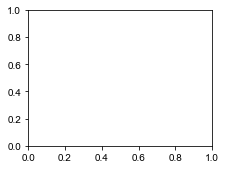

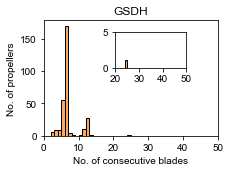

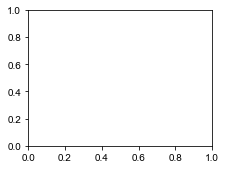

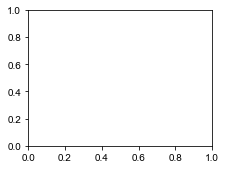

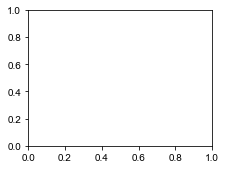

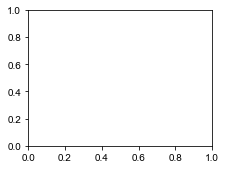

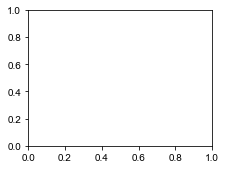

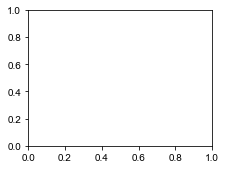

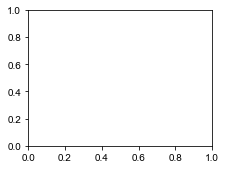

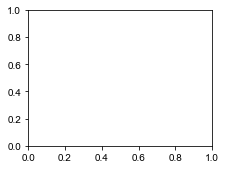

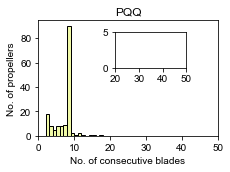

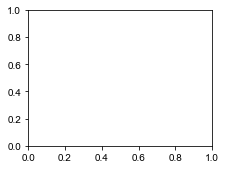

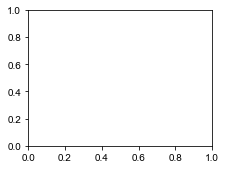

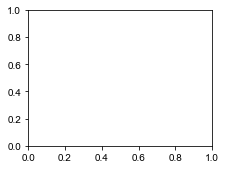

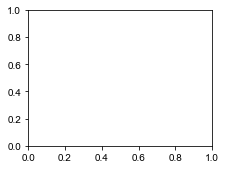

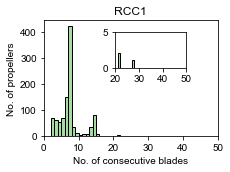

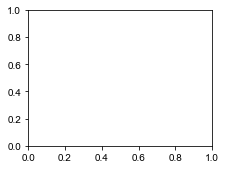

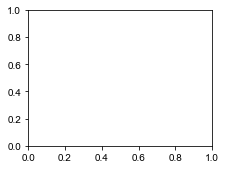

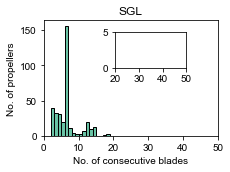

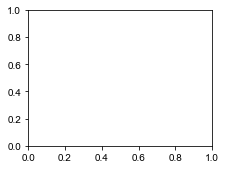

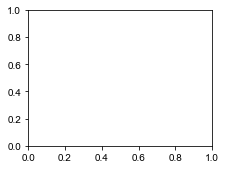

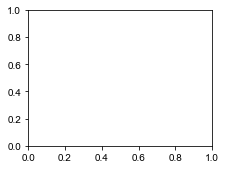

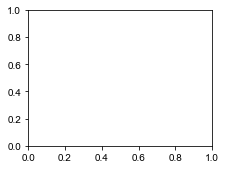

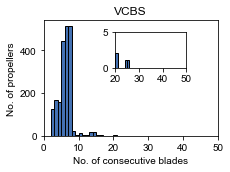

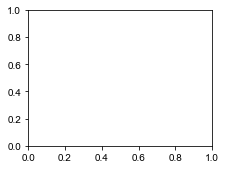

In [35]:
def define_family_colors(families, cmap='Spectral'):
    
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = matplotlib.colors.Normalize(vmin=0,vmax=len(families))
    
    colors = {family: cmap(norm(i)) for i,family in enumerate(families)}
    
    return colors

family_colors = define_family_colors(sorted(set(propellers_df_df.parent_f_name)))
    
for family in family_colors:
    
    f, axs = plt.subplots(1, 1, figsize=(w+0.3,h/2))
    
    tmp = Globally.loc[Globally.parent_f_name == family]
    print('Family: ', family, len(tmp))
    
    if len(tmp) > 150:
        sns.histplot(tmp.detected_topology, bins=range(max(propellers_df.detected_topology)+1), 
                     ax=axs, stat='count', color=family_colors[family], edgecolor='black', linewidth=1, alpha=1)
        axs.set_xlim(0, 50)
        axs.set_ylabel('No. of propellers')
        axs.set_xlabel('No. of consecutive blades')
        axs.title.set_text(family)

        ax1 = f.add_axes([0.5, 0.6, 0.3, 0.2])
        sns.histplot(tmp[tmp.detected_topology>=20].detected_topology, bins=range(20,max(propellers_df.detected_topology)+1),
                     ax=ax1, stat='count', color=family_colors[family], edgecolor='black', linewidth=1, alpha=1)
        ax1.set_xlim(20, 50)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax1.set_ylim(0,5)
        ax1.set_xticks(range(20, 60, 10))

        plt.tight_layout()
        plt.savefig('{}/figS3B-D_{}.pdf'.format(out_dir, family))

## Analyse graveyards/trimmed propellers

In [36]:
# load assemblies searches filtered table
assemblies_df = pd.read_csv('Data/all_searches_concatenated_taxonomy_after_validation_more_than_60_seqID_assemblies.csv_filtered.csv', sep='\t')
assemblies_df = assemblies_df.set_index('Assemblies')
assemblies_df

,NoMembers,Members,Superkingdom,Phylum,Class,Order,Genus,Species,source_targets,refseq,Phylum_label
Assemblies,,,,,,,,,,,
GCA_000827415.1,74,"['KIM31259.1', 'KIM20634.1', 'KIM20042.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Sebacinales,Serendipita,Serendipita vermifera MAFF 305830,"['KIM31259.1', 'KIM20634.1', 'KIM20042.1', 'KI...",na,Eukaryota_Basidiomycota
GCA_004369135.1,72,"['THU93598.1', 'THU79317.1', 'THU94401.1', 'TH...",Eukaryota,Basidiomycota,Agaricomycetes,Agaricales,Dendrothele,Dendrothele bispora CBS 962.96,"['THU93598.1', 'THU79317.1', 'THU94401.1', 'TH...",na,Eukaryota_Basidiomycota
GCA_000827265.1,66,"['KIK66981.1', 'KIK59414.1', 'KIK62334.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Agaricales,Gymnopus,Gymnopus luxurians FD-317 M1,"['KIK66981.1', 'KIK59414.1', 'KIK62334.1', 'KI...",na,Eukaryota_Basidiomycota
GCA_000827215.1,58,"['KIJ33960.1', 'KIJ43762.1', 'KIJ51755.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Geastrales,Sphaerobolus,Sphaerobolus stellatus SS14,"['KIJ33960.1', 'KIJ43762.1', 'KIJ51755.1', 'KI...",na,Eukaryota_Basidiomycota
GCA_000313545.1,55,"['CCA76919.1', 'CCA70723.1', 'CCA66915.1', 'CC...",Eukaryota,Basidiomycota,Agaricomycetes,Sebacinales,Serendipita,Serendipita indica DSM 11827,"['CCA76919.1', 'CCA70723.1', 'CCA66915.1', 'CC...",na,Eukaryota_Basidiomycota
...,...,...,...,...,...,...,...,...,...,...,...
GCA_000999115.1,1,['KKS96890.1'],Bacteria,Candidatus Woesebacteria,na,na,Candidatus,Candidatus Woesebacteria bacterium GW2011_GWB1...,['KKS96890.1'],na,Bacteria_candidate_phyla
GCA_000995185.1,1,['KKS77240.1'],Bacteria,Candidatus Woesebacteria,na,na,Candidatus,Candidatus Woesebacteria bacterium GW2011_GWC1...,['KKS77240.1'],na,Bacteria_candidate_phyla
GCA_001824215.1,1,['OHB12918.1'],Bacteria,Candidatus Zambryskibacteria,na,na,Candidatus,Candidatus Zambryskibacteria bacterium RIFCSPL...,['OHB08870.1'],na,Bacteria_candidate_phyla


In [37]:
# get the mapping of the assembly members to the the target entrezIDs
members_dict = {}
for assembly, row in assemblies_df.iterrows():
    source_targets = (row.source_targets).replace('[','').replace(']','').split(', ')
    members = (row.Members).replace('[','').replace(']','').split(', ')
    
    for i, member in enumerate(members):
        members_dict[member.replace("'","")] = {'ncbi_code': source_targets[i].replace("'",""), 'assembly': assembly}
        members_dict[source_targets[i].replace("'","")] = {'ncbi_code': member.replace("'",""), 'assembly': assembly}

In [38]:
# load graveyards searches table and keep only the lines in the dataframe above
graveyards_df = pd.read_csv('Data/all_searches_concatenated_taxonomy_after_validation_more_than_60_seqID_assemblies_all_all_target_with_graveyard_count.csv', sep='\t')
graveyards_df = graveyards_df.set_index('Assemblies')
graveyards_df = graveyards_df.loc[assemblies_df.index]
graveyards_df

,NoMembers,Members,Superkingdom,Phylum,Class,Order,Genus,Species,source_targets,refseq,Phylum_label,graveyard_counts
Assemblies,,,,,,,,,,,,
GCA_000827415.1,74,"['KIM31259.1', 'KIM20634.1', 'KIM20042.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Sebacinales,Serendipita,Serendipita vermifera MAFF 305830,"['KIM31259.1', 'KIM20634.1', 'KIM20042.1', 'KI...",na,Eukaryota_Basidiomycota,42
GCA_004369135.1,72,"['THU93598.1', 'THU79317.1', 'THU94401.1', 'TH...",Eukaryota,Basidiomycota,Agaricomycetes,Agaricales,Dendrothele,Dendrothele bispora CBS 962.96,"['THU93598.1', 'THU79317.1', 'THU94401.1', 'TH...",na,Eukaryota_Basidiomycota,125
GCA_000827265.1,66,"['KIK66981.1', 'KIK59414.1', 'KIK62334.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Agaricales,Gymnopus,Gymnopus luxurians FD-317 M1,"['KIK66981.1', 'KIK59414.1', 'KIK62334.1', 'KI...",na,Eukaryota_Basidiomycota,97
GCA_000827215.1,58,"['KIJ33960.1', 'KIJ43762.1', 'KIJ51755.1', 'KI...",Eukaryota,Basidiomycota,Agaricomycetes,Geastrales,Sphaerobolus,Sphaerobolus stellatus SS14,"['KIJ33960.1', 'KIJ43762.1', 'KIJ51755.1', 'KI...",na,Eukaryota_Basidiomycota,121
GCA_000313545.1,55,"['CCA76919.1', 'CCA70723.1', 'CCA66915.1', 'CC...",Eukaryota,Basidiomycota,Agaricomycetes,Sebacinales,Serendipita,Serendipita indica DSM 11827,"['CCA76919.1', 'CCA70723.1', 'CCA66915.1', 'CC...",na,Eukaryota_Basidiomycota,24
...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000999115.1,1,['KKS96890.1'],Bacteria,Candidatus Woesebacteria,na,na,Candidatus,Candidatus Woesebacteria bacterium GW2011_GWB1...,['KKS96890.1'],na,Bacteria_candidate_phyla,0
GCA_000995185.1,1,['KKS77240.1'],Bacteria,Candidatus Woesebacteria,na,na,Candidatus,Candidatus Woesebacteria bacterium GW2011_GWC1...,['KKS77240.1'],na,Bacteria_candidate_phyla,0
GCA_001824215.1,1,['OHB12918.1'],Bacteria,Candidatus Zambryskibacteria,na,na,Candidatus,Candidatus Zambryskibacteria bacterium RIFCSPL...,['OHB08870.1'],na,Bacteria_candidate_phyla,0


In [39]:
# load graveyards specific data
graveyards_data = json.load(open('Data/all_searches_concatenated_taxonomy_after_validation_more_than_60_seqID_assemblies_all_all_target_graveyards_with_distances.json','r'))

In [40]:
# add graveyard info to the GLOBALLY REPETITIVE propellers table

temp_data = {}
for assembly in graveyards_data:
    for scaffold in graveyards_data[assembly]:
        for i in range(len(graveyards_data[assembly][scaffold]['graveyard_names'])):
            if 'Closest_target' in graveyards_data[assembly][scaffold]:
                closest_target = graveyards_data[assembly][scaffold]['Closest_target'][i]
                if closest_target is not None:
                    closest_target = members_dict[closest_target]['ncbi_code']

                    if closest_target not in temp_data:
                        temp_data[closest_target] = {'distance': [], 'position': [], 'probability': [], 'assembly': assembly}

                    temp_data[closest_target]['distance'].append(graveyards_data[assembly][scaffold]['Closest_distance'][i])
                    temp_data[closest_target]['position'].append(graveyards_data[assembly][scaffold]['Closest_position'][i])
                    temp_data[closest_target]['probability'].append(graveyards_data[assembly][scaffold]['probabilities'][i])

temp_map = {'assembly':[], 'graveyard_dist': [], 'graveyard_position': [], 'graveyard_probability': [], 'propeller': [], 'no.graveyards': []}
for index, row in full_sequences_df.iterrows():
    ncbi_code = row.ncbi_code.split('_')[0]
    curr_propellers = Globally[Globally['propeller'].str.contains(ncbi_code)]
    
    if ncbi_code in temp_data:
        curr_graveyards = temp_data[ncbi_code]
        curr_assembly = temp_data[ncbi_code]['assembly']
        
        if len(curr_propellers) > 1:
            prot_length = row.protein_length
            closest_props = {}
            for i in range(len(curr_graveyards['position'])):
                # find the closest propeller
                closest_prop = None
                closest_dist = None
                for j, prow in curr_propellers.iterrows():
                    if (curr_graveyards['position'][i] == '5p' and prow.Termini_distance_type == 'N') or (curr_graveyards['position'][i] == '3p' and prow.Termini_distance_type == 'C'):
                        curr_dist = prow.Termini_distance + curr_graveyards['distance'][i]/3
                    else:
                        curr_dist = prot_length - prow.Termini_distance - (prow.Propeller_interval[0]-prow.Propeller_interval[1]) + curr_graveyards['distance'][i]/3
                    
                    if closest_dist is None or curr_dist < closest_dist:
                        closest_dist = curr_dist
                        closest_prop = prow.propeller
                
                if closest_prop not in closest_props:
                    closest_props[closest_prop] = {'graveyard_dist': [], 'graveyard_position': [], 'graveyard_probability': []}
                
                closest_props[closest_prop]['graveyard_dist'].append(curr_graveyards['distance'][i])
                closest_props[closest_prop]['graveyard_position'].append(curr_graveyards['position'][i])
                closest_props[closest_prop]['graveyard_probability'].append(curr_graveyards['probability'][i])
            
            for prop in closest_props:
                temp_map['graveyard_dist'].append(closest_props[prop]['graveyard_dist'])
                temp_map['graveyard_position'].append(closest_props[prop]['graveyard_position'])
                temp_map['graveyard_probability'].append(closest_props[prop]['graveyard_probability'])
                temp_map['propeller'].append('{}_#1'.format(prop))
                temp_map['no.graveyards'].append(len(closest_props[prop]['graveyard_probability']))
                temp_map['assembly'].append(curr_assembly)
                 
        else:
            temp_map['graveyard_dist'].append(curr_graveyards['distance'])
            temp_map['graveyard_position'].append(curr_graveyards['position'])
            temp_map['graveyard_probability'].append(curr_graveyards['probability'])
            temp_map['propeller'].append('{}_#1'.format(ncbi_code))
            temp_map['no.graveyards'].append(len(curr_graveyards['probability']))
            temp_map['assembly'].append(curr_assembly)
#     else:
#         for j, prow in curr_propellers.iterrows():
#             temp_map['graveyard_dist'].append(np.nan)
#             temp_map['graveyard_position'].append(np.nan)
#             temp_map['graveyard_probability'].append(np.nan)
#             temp_map['propeller'].append(prow.propeller)
#             temp_map['no.graveyards'].append(np.nan)
            
#             ncbi_code = prow.propeller.split('_#')[0]
#             if ncbi_code in members_dict:
#                 temp_map['assembly'].append(members_dict[ncbi_code]['assembly'])
#             else:
#                 temp_map['assembly'].append(np.nan)
            
temp_map = pd.DataFrame(temp_map).sort_values(by='no.graveyards')
temp_map = temp_map.set_index('propeller')

In [41]:
# merge with the globally repetitive propellers dataframe and update assembly information
Globally = Globally.set_index('propeller')
Globally = Globally.join(temp_map)

assemblies = []
for i, row in Globally.iterrows():
    ncbi_code = i.split('_#')[0]
    if ncbi_code in members_dict:
        assembly = members_dict[ncbi_code]['assembly']
    else:
        assembly = np.nan
    assemblies.append(assembly)
    
Globally['assembly'] = assemblies
Globally.sort_values(by='no.graveyards')

,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,...,Termini_distance,Termini_distance_type,Protein_coverage,Propeller_probability,Propeller_interval,assembly,graveyard_dist,graveyard_position,graveyard_probability,no.graveyards
propeller,,,,,,,,,,,,,,,,,,,,,
KAA6412551.1_#1,DPPIV_N,9-bladed,14,80.95,Eukaryota,Ascomycota,Lecanoromycetes,Umbilicariales,Umbilicaria,Umbilicaria pustulata,...,85,C,37.444374,100.0,"[899, 1488]",GCA_008636195.1,[3131],[5p],[26.4],1.0
RKZ45142.1_#1,ANAPC4_WD40,9-bladed,14,71.88,Bacteria,Proteobacteria,Gammaproteobacteria,na,Gammaproteobacteria,Gammaproteobacteria bacterium,...,40,N,83.720930,100.0,"[40, 616]",GCA_003645245.1,[1838],[3p],[1.2],1.0
KIM73866.1_#1,ANAPC4_WD40,7-bladed,5,80.49,Eukaryota,Basidiomycota,Agaricomycetes,Atheliales,Piloderma,Piloderma croceum F 1598,...,98,C,21.974522,100.0,"[637, 844]",GCA_000827315.1,[444],[5p],[4.8],1.0
KIM72192.1_#1,ANAPC4_WD40,7-bladed,3,94.59,Eukaryota,Basidiomycota,Agaricomycetes,Atheliales,Piloderma,Piloderma croceum F 1598,...,0,C,98.319328,99.8,"[2, 119]",GCA_000827315.1,[7200],[5p],[98.3],1.0
KIM85013.1_#1,ANAPC4_WD40,7-bladed,6,73.97,Eukaryota,Basidiomycota,Agaricomycetes,Atheliales,Piloderma,Piloderma croceum F 1598,...,0,C,88.560886,100.0,"[31, 271]",GCA_000827315.1,[2921],[5p],[100.0],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WP_020404944.1_#2,SGL,6-bladed,2,72.97,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanothermococcus,Methanothermococcus thermolithotrophicus,...,0,C,39.613527,98.3,"[125, 207]",GCF_000376965.1,NaN,NaN,NaN,NaN
WP_013142820.1_#1,SGL,6-bladed,7,65.83,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Staphylothermus,Staphylothermus hellenicus DSM 12710,...,30,N,29.312169,99.9,"[30, 307]",GCF_000092465.1,NaN,NaN,NaN,NaN
RZD33336.1_#1,ANAPC4_WD40,8-bladed,8,62.50,Archaea,Euryarchaeota,na,na,Euryarchaeota,Euryarchaeota archaeon,...,30,N,43.360434,100.0,"[30, 350]",GCA_004195655.1,NaN,NaN,NaN,NaN


### Compare first the distances of globally repetitive propellers to the N and C-termini

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


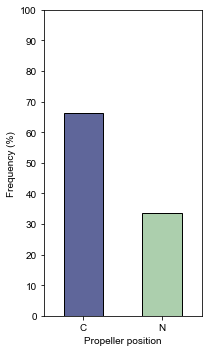

In [42]:
# get the distribution of GLOBALLY REPETITIVE propeller distances to the termini, separated by N and C 

h = 5
w = 3
colors=['#5F669A','#ACCFAD']

plt.figure(figsize=(w, h))
(Globally.Termini_distance_type.value_counts()*100/len(Globally)).plot(kind='bar', rot=0, 
                                                                           colors=colors,
                                                                           edgecolor='black')
plt.ylabel('Frequency (%)')
plt.yticks(range(0,101,10))
plt.ylim(0,100)
plt.xlabel('Propeller position')
plt.tight_layout()
plt.savefig('{}/fig6A.pdf'.format(out_dir))

N-terminal:  1
C-terminal:  0


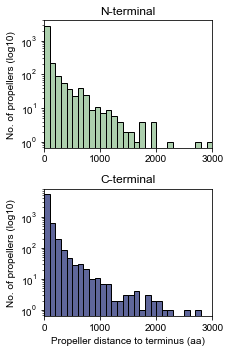

In [43]:
f, axs = plt.subplots(2, 1, figsize=(w+0.3,h))

# first the N-terminal propellers
Nterm = Globally.loc[Globally.Termini_distance_type == 'N']
print('N-terminal: ', Nterm.Termini_distance.min())

sns.histplot(Nterm.Termini_distance, bins=np.arange(0, 3001, 100), 
             ax=axs[0], stat='count', color=colors[1], edgecolor='black', linewidth=1, alpha=1)
axs[0].set_xlim(-1, 3001)
axs[0].set_xlabel('')
axs[0].set_ylabel('No. of propellers (log10)')
axs[0].set_yscale('log')
axs[0].title.set_text('N-terminal')

# now the C-terminal propellers
Cterm = Globally.loc[Globally.Termini_distance_type == 'C']
print('C-terminal: ', Cterm.Termini_distance.min())

sns.histplot(Cterm.Termini_distance, bins=np.arange(0, 3001, 100), 
             ax=axs[1], stat='count', color=colors[0], edgecolor='black', linewidth=1, alpha=1)
axs[1].set_xlim(-1, 3001)
axs[1].set_xlabel('Propeller distance to terminus (aa)')
axs[1].set_ylabel('No. of propellers (log10)')
axs[1].set_yscale('log')
axs[1].title.set_text('C-terminal')

plt.tight_layout()
plt.savefig('{}/fig6B-D.pdf'.format(out_dir))

In [44]:
print('Percentage of Nterm prop. at less than 100 aa from term:',len(Nterm.loc[Nterm.Termini_distance < 100])*100/len(Nterm))
print('Percentage of Nterm prop. at less than 50 aa from term:',len(Nterm.loc[Nterm.Termini_distance < 50])*100/len(Nterm))

print('\nPercentage of Cterm prop. at less than 100 aa from term:',len(Cterm.loc[Cterm.Termini_distance < 100])*100/len(Cterm))
print('Percentage of Cterm prop. at less than 50 aa from term:',len(Cterm.loc[Cterm.Termini_distance < 50])*100/len(Cterm))


Percentage of Nterm prop. at less than 100 aa from term: 82.7966881324747
Percentage of Nterm prop. at less than 50 aa from term: 68.01594602882551

Percentage of Cterm prop. at less than 100 aa from term: 82.903981264637
Percentage of Cterm prop. at less than 50 aa from term: 62.4512099921936


### Now look at the graveyards 


In [73]:
Globally_with_assemblies_only = Globally.loc[Globally.assembly.notnull()]
# Globally_with_assemblies_only
print('Unique no. of assemblies:', len(set(Globally_with_assemblies_only.assembly)))
print('No. of propellers mapped to assemblies:', len(Globally_with_assemblies_only))
print('% of propellers mapped to assemblies:', len(Globally_with_assemblies_only)*100/len(Globally))

Globally_with_graveyards_only = Globally.loc[Globally['no.graveyards'].notnull()]
print('\nNo. of graveyards found:', Globally_with_graveyards_only['no.graveyards'].sum())
print('Unique no. of assemblies with graveyards:', len(set(Globally_with_graveyards_only.assembly)))
print('No. of propellers close to graveyards:', len(Globally_with_graveyards_only))
print('% of propellers close to graveyards:', len(Globally_with_graveyards_only)*100/len(Globally_with_assemblies_only))

Unique no. of assemblies: 3175
No. of propellers mapped to assemblies: 7329
% of propellers mapped to assemblies: 75.82247051520794

No. of graveyards found: 3325.0
Unique no. of assemblies with graveyards: 584
No. of propellers close to graveyards: 1553
% of propellers close to graveyards: 21.189793969163595


In [46]:
Globally_with_graveyards_only

,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,...,Termini_distance,Termini_distance_type,Protein_coverage,Propeller_probability,Propeller_interval,assembly,graveyard_dist,graveyard_position,graveyard_probability,no.graveyards
propeller,,,,,,,,,,,,,,,,,,,,,
RKU07382.1_#1,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,25,C,83.235294,99.9,"[32, 315]",GCA_003635265.1,"[1624, 1406, 2046]","[3p, 3p, 3p]","[1.6, 6.3, 2.0]",3.0
RKU32370.1_#1,Peptidase_S9,7-bladed,6,61.63,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,25,C,82.461538,99.9,"[32, 300]",GCA_003635245.1,"[412, 802, 294]","[3p, 3p, 3p]","[9.2, 98.7, 99.4]",3.0
RKU06605.1_#1,Peptidase_S9,7-bladed,5,60.95,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,27,N,77.710843,99.9,"[27, 285]",GCA_003635265.1,[2023],[5p],[9.5],1.0
RKU11315.1_#1,Peptidase_S9,7-bladed,6,60.12,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,32,C,78.208955,99.9,"[41, 303]",GCA_003635265.1,"[5806, 6893]","[3p, 3p]","[6.1, 3.6]",2.0
PIP12065.1_#1,Peptidase_S9,7-bladed,7,65.77,Bacteria,na,na,na,bacterium,bacterium (Candidatus Stahlbacteria) CG23_comb...,...,39,N,69.469027,99.8,"[39, 353]",GCA_002771845.1,[575],[5p],[35.3],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KAE8132446.1_#1,ANAPC4_WD40,7-bladed,2,91.89,Eukaryota,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillus,Aspergillus pseudotamarii,...,106,C,8.386509,99.6,"[899, 991]",GCF_009193445.1,[1578],[3p],[5.7],1.0
KIK56955.1_#1,ANAPC4_WD40,7-bladed,6,80.38,Eukaryota,Basidiomycota,Agaricomycetes,Agaricales,Gymnopus,Gymnopus luxurians FD-317 M1,...,160,C,21.835749,100.0,"[649, 875]",GCA_000827265.1,[61747],[3p],[96.2],1.0
GAW26223.1_#1,Cytochrom_D1,8-bladed,7,83.78,Eukaryota,Ascomycota,Sordariomycetes,Xylariales,Rosellinia,Rosellinia necatrix,...,15,N,69.158879,99.9,"[15, 311]",GCA_001445595.3,[133],[3p],[98.1],1.0


In [47]:
graveyards_df_df = {col: [] for col in Globally_with_graveyards_only.columns}
graveyards_df_df['propellers'] = []

for index, row in Globally_with_graveyards_only.iterrows():
    for i, graveyard in enumerate(row.graveyard_position):
        graveyards_df_df['propellers'].append(index)
        
        for col in graveyards_df_df:
            if col != 'propellers':
                if 'graveyard' not in col:
                    graveyards_df_df[col].append(row[col])
                elif 'no.' not in col:
                    graveyards_df_df[col].append(row[col][i])
                else:
                    graveyards_df_df[col].append(1)

graveyards_df_df = pd.DataFrame(graveyards_df_df)
graveyards_df_df

,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,...,Termini_distance_type,Protein_coverage,Propeller_probability,Propeller_interval,assembly,graveyard_dist,graveyard_position,graveyard_probability,no.graveyards,propellers
0,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,C,83.235294,99.9,"[32, 315]",GCA_003635265.1,1624,3p,1.6,1,RKU07382.1_#1
1,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,C,83.235294,99.9,"[32, 315]",GCA_003635265.1,1406,3p,6.3,1,RKU07382.1_#1
2,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,C,83.235294,99.9,"[32, 315]",GCA_003635265.1,2046,3p,2.0,1,RKU07382.1_#1
3,Peptidase_S9,7-bladed,6,61.63,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,C,82.461538,99.9,"[32, 300]",GCA_003635245.1,412,3p,9.2,1,RKU32370.1_#1
4,Peptidase_S9,7-bladed,6,61.63,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,C,82.461538,99.9,"[32, 300]",GCA_003635245.1,802,3p,98.7,1,RKU32370.1_#1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,Cytochrom_D1,8-bladed,7,83.78,Eukaryota,Ascomycota,Sordariomycetes,Xylariales,Rosellinia,Rosellinia necatrix,...,N,69.158879,99.9,"[15, 311]",GCA_001445595.3,133,3p,98.1,1,GAW26223.1_#1
3321,Cytochrom_D1,8-bladed,9,88.10,Eukaryota,Basidiomycota,Agaricomycetes,Amylocorticiales,Plicaturopsis,Plicaturopsis crispa FD-325 SS-3,...,N,84.064665,100.0,"[2, 366]",GCA_000827205.1,545,3p,24.3,1,KII85352.1_#1
3322,SGL,7-bladed,6,77.78,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Schekmanbacteria bacterium RIFCSPHI...,...,C,95.588235,98.3,"[13, 338]",GCA_001790785.1,3,5p,21.9,1,OGL50168.1_#1
3323,SGL,7-bladed,6,77.78,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Schekmanbacteria bacterium RIFCSPHI...,...,C,95.588235,98.3,"[13, 338]",GCA_001790785.1,2699,5p,18.0,1,OGL50168.1_#1


In [48]:
print('\n% of graveyards propellers <50%:', len(graveyards_df_df.loc[graveyards_df_df.graveyard_probability < 50])/len(graveyards_df_df))
print('% of graveyards propellers >70%:', len(graveyards_df_df.loc[graveyards_df_df.graveyard_probability > 70])/len(graveyards_df_df))
print('No. of graveyards propellers >70%:', len(graveyards_df_df.loc[graveyards_df_df.graveyard_probability > 70]))
print('No. of propellers close to graveyards propellers >70%:', len(set(graveyards_df_df.loc[graveyards_df_df.graveyard_probability > 70].propellers)))



% of graveyards propellers <50%: 0.8631578947368421
% of graveyards propellers >70%: 0.12872180451127818
No. of graveyards propellers >70%: 428
No. of propellers close to graveyards propellers >70%: 320


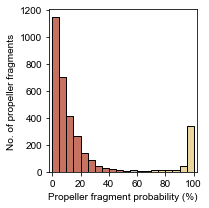

In [49]:
# Plot the remnants probability distribution 

h = 3
w = 3
colors=['#C77161','#C0C0C0','#EAD59D']

plt.figure(figsize=(w, h))
sns.histplot(graveyards_df_df.loc[graveyards_df_df.graveyard_probability <= 50].graveyard_probability, bins=np.arange(0, 101, 5), 
            stat='count', color=colors[0], edgecolor='black', linewidth=1, alpha=1)

sns.histplot(graveyards_df_df.loc[(graveyards_df_df.graveyard_probability < 70) & (graveyards_df_df.graveyard_probability > 50)].graveyard_probability, bins=np.arange(0, 101, 5), 
            stat='count', color=colors[1], edgecolor='black', linewidth=1, alpha=1)

sns.histplot(graveyards_df_df.loc[graveyards_df_df.graveyard_probability >= 70].graveyard_probability, bins=np.arange(0, 101, 5), 
            stat='count', color=colors[2], edgecolor='black', linewidth=1, alpha=1)

plt.ylabel('No. of propeller fragments')
plt.xticks(range(0,101,20))
plt.xlim(-2,102)
plt.xlabel('Propeller fragment probability (%)')
plt.tight_layout()
plt.savefig('{}/fig7A.pdf'.format(out_dir))

In [50]:
# add remnant classification
classification = []
for index, row in graveyards_df_df.iterrows():
    if row.graveyard_probability >= 70:
        classification.append('High')
    elif row.graveyard_probability <= 50:
        classification.append('Low')
    else:
        classification.append(np.nan)

graveyards_df_df['remnant_class'] = classification
graveyards_df_df

,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,...,Protein_coverage,Propeller_probability,Propeller_interval,assembly,graveyard_dist,graveyard_position,graveyard_probability,no.graveyards,propellers,remnant_class
0,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,83.235294,99.9,"[32, 315]",GCA_003635265.1,1624,3p,1.6,1,RKU07382.1_#1,Low
1,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,83.235294,99.9,"[32, 315]",GCA_003635265.1,1406,3p,6.3,1,RKU07382.1_#1,Low
2,Peptidase_S9,7-bladed,6,62.48,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,83.235294,99.9,"[32, 315]",GCA_003635265.1,2046,3p,2.0,1,RKU07382.1_#1,Low
3,Peptidase_S9,7-bladed,6,61.63,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,82.461538,99.9,"[32, 300]",GCA_003635245.1,412,3p,9.2,1,RKU32370.1_#1,Low
4,Peptidase_S9,7-bladed,6,61.63,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Poribacteria bacterium,...,82.461538,99.9,"[32, 300]",GCA_003635245.1,802,3p,98.7,1,RKU32370.1_#1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,Cytochrom_D1,8-bladed,7,83.78,Eukaryota,Ascomycota,Sordariomycetes,Xylariales,Rosellinia,Rosellinia necatrix,...,69.158879,99.9,"[15, 311]",GCA_001445595.3,133,3p,98.1,1,GAW26223.1_#1,High
3321,Cytochrom_D1,8-bladed,9,88.10,Eukaryota,Basidiomycota,Agaricomycetes,Amylocorticiales,Plicaturopsis,Plicaturopsis crispa FD-325 SS-3,...,84.064665,100.0,"[2, 366]",GCA_000827205.1,545,3p,24.3,1,KII85352.1_#1,Low
3322,SGL,7-bladed,6,77.78,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Schekmanbacteria bacterium RIFCSPHI...,...,95.588235,98.3,"[13, 338]",GCA_001790785.1,3,5p,21.9,1,OGL50168.1_#1,Low
3323,SGL,7-bladed,6,77.78,Bacteria,candidate phyla,na,na,Candidatus,Candidatus Schekmanbacteria bacterium RIFCSPHI...,...,95.588235,98.3,"[13, 338]",GCA_001790785.1,2699,5p,18.0,1,OGL50168.1_#1,Low


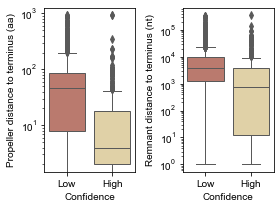

In [51]:
h = 3
w = 2
colors=['#C77161','#EAD59D']

f, axs = plt.subplots(1, 2, figsize=(w*2,h))

sns.boxplot(y = 'Termini_distance', data = graveyards_df_df.loc[graveyards_df_df.remnant_class.notnull()],
            x = 'remnant_class', palette=colors, linewidth=1, ax=axs[0])

axs[0].set_ylabel('Propeller distance to terminus (aa)')
axs[0].set_yscale('log')
axs[0].set_xlabel('Confidence')

sns.boxplot(y = 'graveyard_dist', data = graveyards_df_df.loc[graveyards_df_df.remnant_class.notnull()],
            x = 'remnant_class', palette=colors, linewidth=1, ax=axs[1])

axs[1].set_ylabel('Remnant distance to terminus (nt)')
axs[1].set_yscale('log')
axs[1].set_xlabel('Confidence')


plt.tight_layout()
plt.savefig('{}/fig7B-C.pdf'.format(out_dir))

In [52]:
high_confidence_graveyards = graveyards_df_df.loc[graveyards_df_df.remnant_class == 'High']
high_confidence_graveyards.loc[(high_confidence_graveyards.Superkingdom == 'Bacteria') & (high_confidence_graveyards.graveyard_probability < 80)].sort_values(by=['graveyard_dist','Termini_distance']).head(20)


,parent_f_name,parent_t_name,detected_topology,blades_similarity,Superkingdom,Phylum,Class,Order,Genus,Species,...,Protein_coverage,Propeller_probability,Propeller_interval,assembly,graveyard_dist,graveyard_position,graveyard_probability,no.graveyards,propellers,remnant_class
2784,FG-GAP_1st,7-bladed,3,71.62,Bacteria,Planctomycetes,Candidatus Brocadiae,Candidatus Brocadiales,Candidatus,Candidatus Brocadia fulgida,...,77.108434,97.9,"[36, 292]",GCA_000987375.1,3,3p,74.1,1,KKO20815.1_#1,High
2665,RCC1,7-bladed,4,71.22,Bacteria,Actinobacteria,Actinobacteria,Pseudonocardiales,Saccharomonospora,Saccharomonospora sp. 31sw,...,38.252427,99.7,"[4, 201]",GCF_004519465.1,5,5p,71.1,1,QBQ61718.1_#1,High
2610,Kelch,6-bladed,4,75.85,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,...,44.547564,98.6,"[176, 368]",GCA_003221275.1,8,3p,77.6,1,PYL67592.1_#1,High
2845,DPPIV_N,8-bladed,12,63.64,Bacteria,Chloroflexi,na,na,Chloroflexi,Chloroflexi bacterium,...,62.470309,100.0,"[37, 563]",GCA_004297765.1,1435,3p,74.2,1,TAK36088.1_#1,High
79,PSII_BNR,7-bladed,3,65.79,Bacteria,Verrucomicrobia,na,na,Verrucomicrobia,Verrucomicrobia bacterium,...,53.636364,97.9,"[52, 170]",GCA_003218945.1,3560,3p,73.2,1,PYK43202.1_#1,High
2796,FG-GAP_1st,7-bladed,6,79.73,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Robiginitomaculum,Robiginitomaculum sp.,...,56.026059,98.5,"[33, 549]",GCA_002732685.1,4791,5p,78.2,1,PHQ68307.1_#1,High


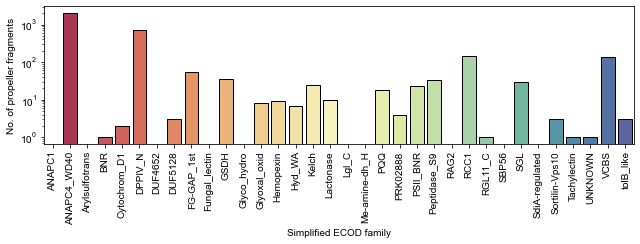

In [54]:
# check proportion of remnants per number of propellers
tmp_data = {'Family':[], 'Proportion': []}

for family in family_colors:
    noprop = len(Globally.loc[Globally.parent_f_name == family])
    nograve = len(graveyards_df_df.loc[graveyards_df_df.parent_f_name == family])
    
    tmp_data['Family'].append(family)
    try:
        tmp_data['Proportion'].append(nograve)
    except:
        tmp_data['Proportion'].append(0)

tmp_data = pd.DataFrame(tmp_data)

f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(9,3.5))

sns.barplot(y='Proportion', x='Family', data=tmp_data, palette='Spectral', edgecolor='black', linewidth=1, log=True,
              order=sorted(set(tmp_data.Family)), ax=ax1)

ax1.set_ylabel('No. of propeller fragments')
# ax1.set_ylim(0, 1)
ax1.set_xlabel('')
ax1.set_xticklabels(rotation=90, labels = sorted(set(tmp_data.Family)))
ax1.set_xlim(-0.5, len(sorted(set(tmp_data.Family)))-0.5)
plt.xlabel('Simplified ECOD family')
plt.tight_layout()
plt.savefig('{}/figS5a.pdf'.format(out_dir))

<Figure size 432x288 with 0 Axes>

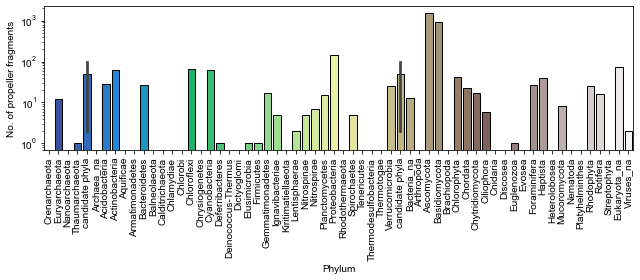

In [55]:
tmp_data = {'Taxlabel':[], 'Proportion': []}

Globally['taxlabel'] = ['{}_{}'.format(row.Superkingdom, row.Phylum) for index, row in Globally.iterrows()]
graveyards_df_df['taxlabel'] = ['{}_{}'.format(row.Superkingdom, row.Phylum) for index, row in graveyards_df_df.iterrows()]

for taxlabel in sorted(set(propellers_df_df.taxlabel)):
    noprop = len(Globally.loc[Globally.taxlabel == taxlabel])
    nograve = len(graveyards_df_df.loc[graveyards_df_df.taxlabel == taxlabel])
    
    if '_na' not in taxlabel:
        tmp_data['Taxlabel'].append(taxlabel.split('_')[-1])
    else:
        tmp_data['Taxlabel'].append(taxlabel)
    try:
        tmp_data['Proportion'].append(nograve)
    except:
        tmp_data['Proportion'].append(0)

tmp_data = pd.DataFrame(tmp_data)

plt.clf()
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(9,4))
sns.barplot(y='Proportion', x='Taxlabel', data=tmp_data, palette='terrain', edgecolor='black', linewidth=1, log=True,
              order=tmp_data.Taxlabel, ax=ax1)

ax1.set_ylabel('No. of propeller fragments')
# ax1.set_ylim(0, 1)
ax1.set_xlabel('')
ax1.set_xticklabels(rotation=90, labels = tmp_data.Taxlabel)
ax1.set_xlim(-0.5, len(sorted(set(tmp_data.Taxlabel)))+0.5)
plt.xlabel('Phylum')
plt.tight_layout()
plt.savefig('{}/figS5c.pdf'.format(out_dir))

# tmp_data

Family:  ANAPC1 0
Family:  ANAPC4_WD40 2072
Family:  Arylsulfotrans 0
Family:  BNR 1
Family:  Cytochrom_D1 2
Family:  DPPIV_N 704
Family:  DUF4652 0
Family:  DUF5128 3
Family:  FG-GAP_1st 56
Family:  Fungal_lectin 0
Family:  GSDH 36
Family:  Glyco_hydro 0
Family:  Glyoxal_oxid 8
Family:  Hemopexin 9
Family:  Hyd_WA 7
Family:  Kelch 24


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Family:  Lactonase 10
Family:  Lgl_C 0
Family:  Me-amine-dh_H 0
Family:  PQQ 18
Family:  PRK02888 4
Family:  PSII_BNR 23
Family:  Peptidase_S9 33
Family:  RAG2 0
Family:  RCC1 142
Family:  RGL11_C 1
Family:  SBP56 0
Family:  SGL 29
Family:  SdiA-regulated 0
Family:  Sortilin-Vps10 3
Family:  Tachylectin 1
Family:  UNKNOWN 1
Family:  VCBS 135
Family:  tolB_like 3


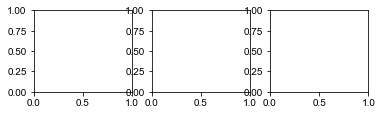

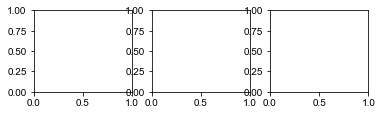

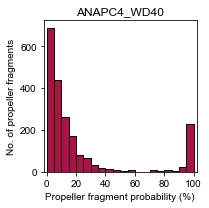

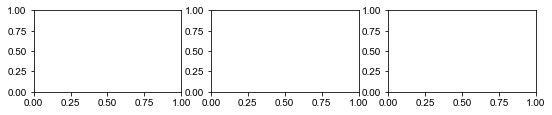

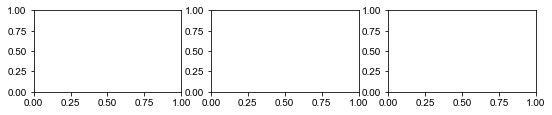

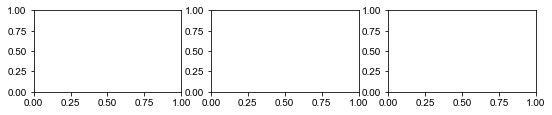

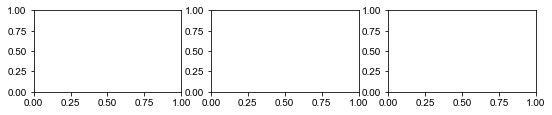

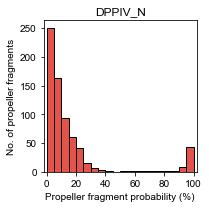

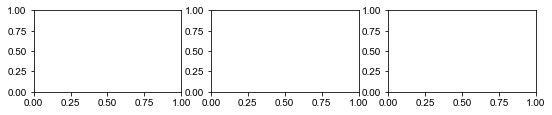

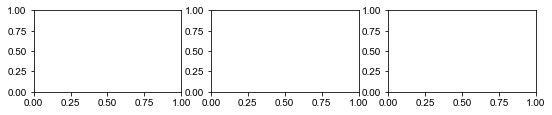

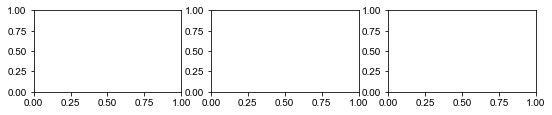

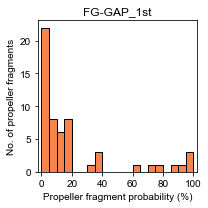

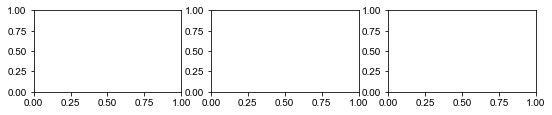

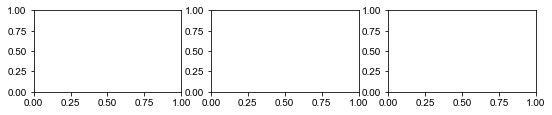

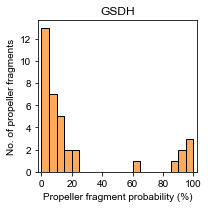

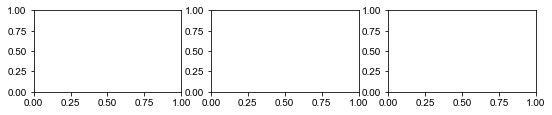

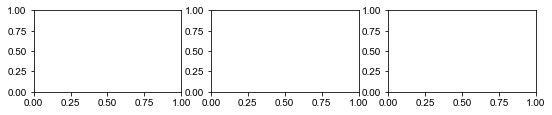

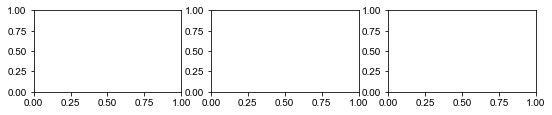

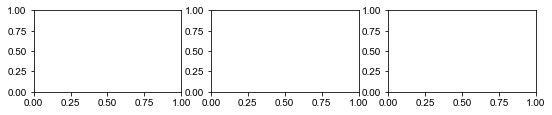

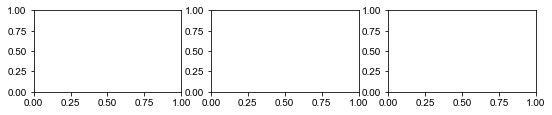

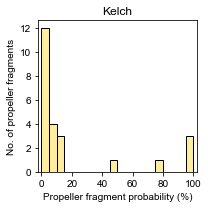

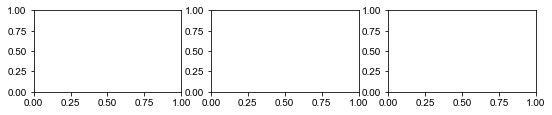

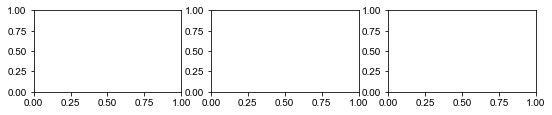

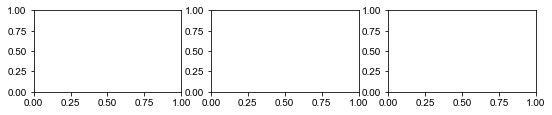

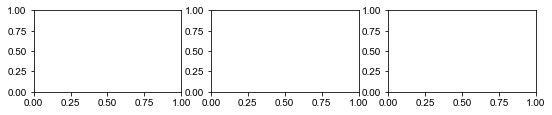

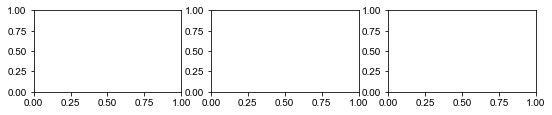

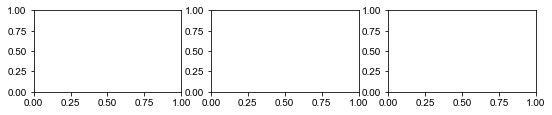

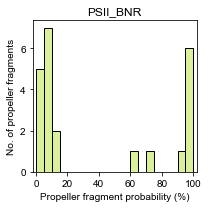

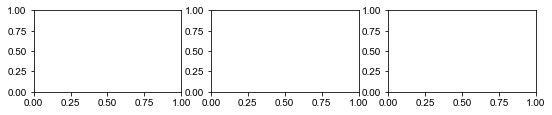

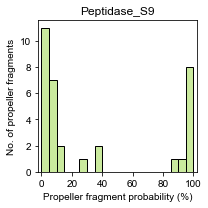

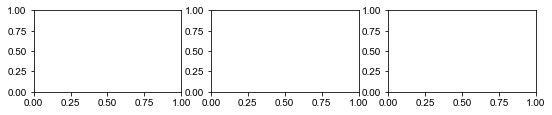

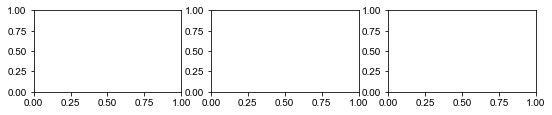

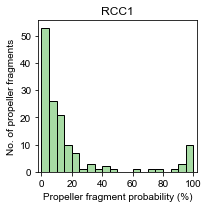

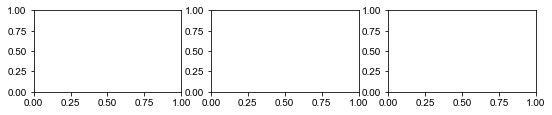

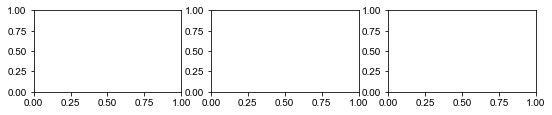

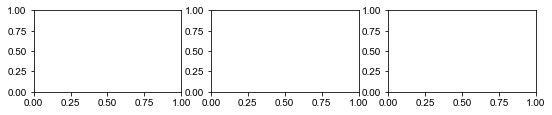

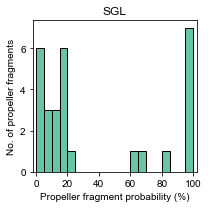

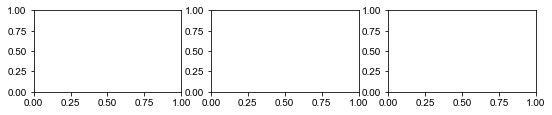

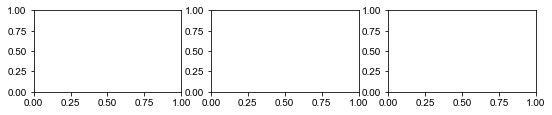

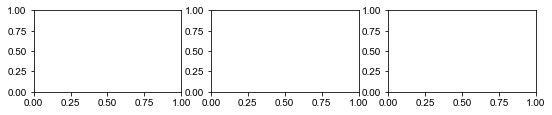

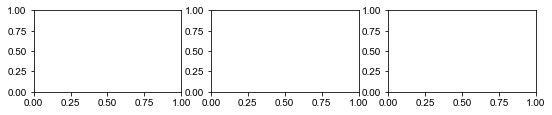

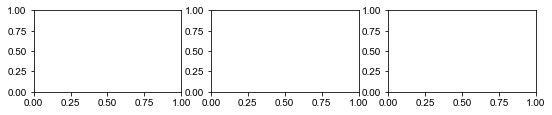

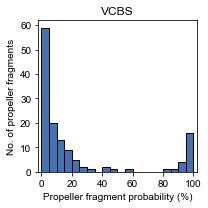

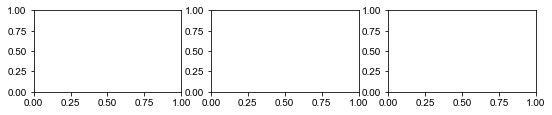

In [56]:
# check family distribution
for family in family_colors:
    
    f, axs = plt.subplots(1, 3, figsize=(w*3,h/2))
    
    tmp = graveyards_df_df.loc[graveyards_df_df.parent_f_name == family]
    print('Family: ', family, len(tmp))
    
    if len(tmp) > 20:
        h = 3
        w = 3

        plt.figure(figsize=(w, h))
        sns.histplot(tmp.graveyard_probability, bins=np.arange(0, 101, 5), 
                    stat='count', color=family_colors[family], edgecolor='black', linewidth=1, alpha=1)

        plt.ylabel('No. of propeller fragments')
        plt.xticks(range(0,101,20))
        plt.xlim(-2,102)
        plt.xlabel('Propeller fragment probability (%)')
        plt.title(family)
        plt.tight_layout()
        plt.savefig('{}/figS5b_{}.pdf'.format(out_dir, family))